# Running speed module

All BrainTV projects need to provide running speed data to end users. Currently each project does this differently, which makes the code hard to maintain and the user experience unpredictable.



In [1]:
from pathlib import Path
from pprint import pprint

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from scipy.ndimage import median_filter

from allensdk.brain_observatory.extract_running_speed.__main__ import main

In [2]:
def roundtrip(inputs):
    output_path = main(**inputs)["output_path"] 
    return pd.read_hdf(output_path, key="running_speed")
    
def midpoints(obt):
    return obt["start_time"] + (obt["end_time"] - obt["start_time"]) / 2

def remove_outliers(data, filter_width=5, percentile=99.9999):
    data = np.array(data)
    filtered_data = median_filter(data, size=filter_width)
    diffs = np.fabs(data - filtered_data)
    data[np.where(diffs > np.percentile(diffs, percentile))[0]] = np.nan
    return data

In [3]:
local_dir = Path("extract_running_speed_examples")

wheel_radius = 6.5 * 2.54 / 2
subject_position = 2 / 3

### Ecephys

In [4]:
ec_storage = Path(
    "/", "allen", "programs", "braintv", "production", "neuralcoding", 
    "prod0", "specimen_717038288", "ecephys_session_732592105"
)

ec_inputs = {
    "sync_h5_path": ec_storage / Path("732592105_404553_20180808.sync"),
    "stimulus_pkl_path": ec_storage / Path("732592105_404553_20180808.stim.pkl"),
    "output_path": local_dir / Path("ecephys_running_speed.h5"),
    "wheel_radius": wheel_radius,
    "subject_position": subject_position
}

ec_obt = roundtrip(ec_inputs)

/home/nile/Desktop/715_running/allensdk/allensdk/brain_observatory/extract_running_speed/__main__.py:34: UserWarning: unable to read vsig from this stimulus file
  warnings.warn(f"unable to read {key} from this stimulus file")
/home/nile/Desktop/715_running/allensdk/allensdk/brain_observatory/extract_running_speed/__main__.py:34: UserWarning: unable to read vin from this stimulus file
  warnings.warn(f"unable to read {key} from this stimulus file")


In [5]:
ec_obt.head()

,start_time,end_time,velocity,net_rotation
0,21.52729,21.55997,24.954197,0.148183
1,21.55997,21.57787,42.648001,0.138716
2,21.57787,21.60883,23.930170,0.134624
3,21.60883,21.62547,45.849774,0.138632
4,21.62547,21.66045,21.959595,0.139578


<IPython.core.display.Javascript object>


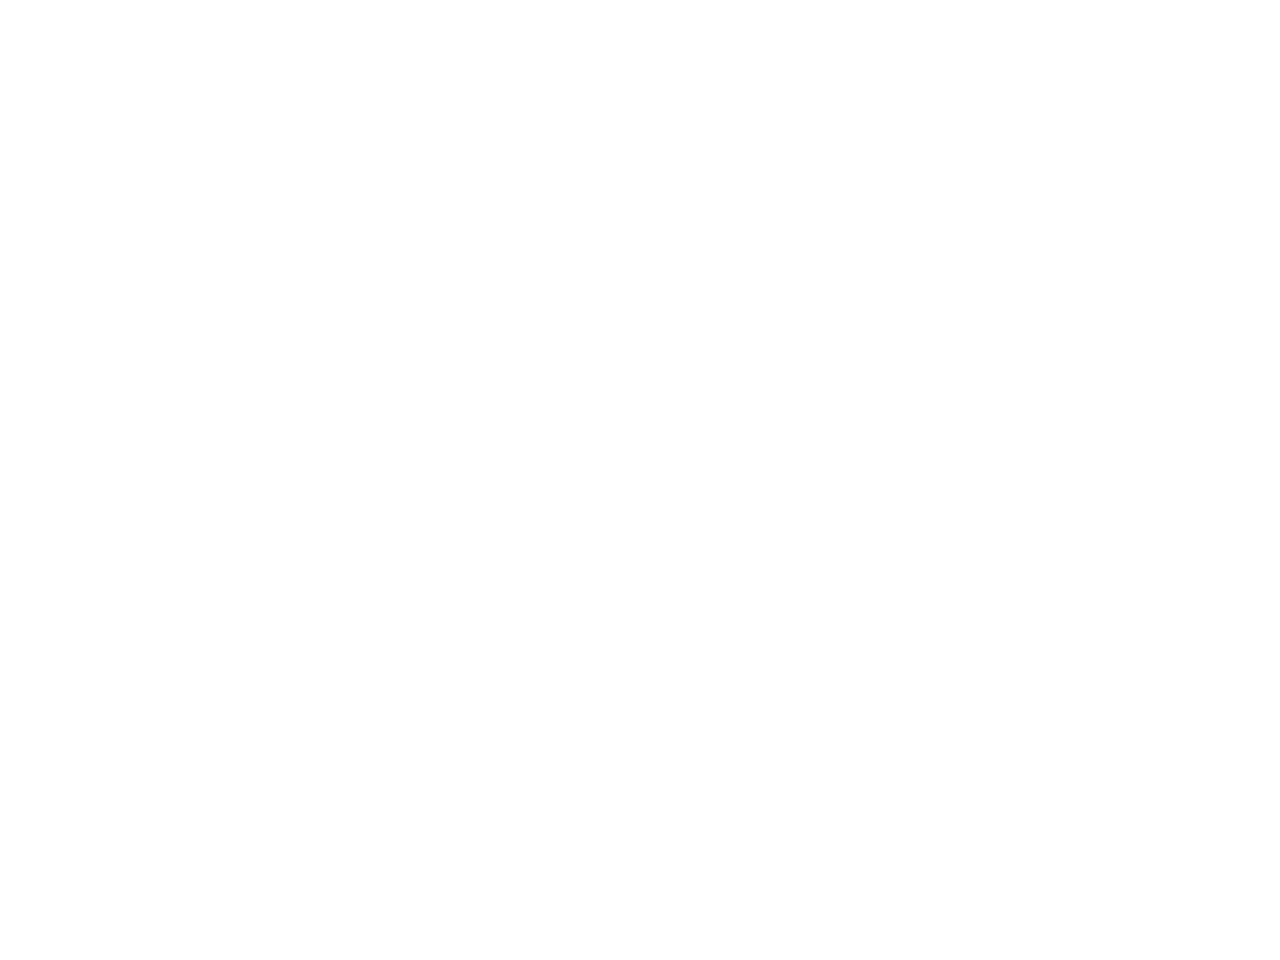

In [6]:
%matplotlib notebook
plt.plot(midpoints(ec_obt), ec_obt["velocity"])

## Visbeh

In [7]:
vb_storage = Path(
    "/allen/programs/braintv/production/visualbehavior/prod0/specimen_843387586/ophys_session_884528231/"
)

vb_inputs = {
    "sync_h5_path": vb_storage / Path("884528231_sync.h5"),
    "stimulus_pkl_path": vb_storage / Path("884528231_stim.pkl"),
    "output_path": local_dir / Path("vb_running_speed.h5"),
    "wheel_radius": wheel_radius,
    "subject_position": subject_position
}

vb_obt = roundtrip(vb_inputs)

In [8]:
vb_obt.head()

,start_time,end_time,velocity,net_rotation
0,6.46675,6.48474,0.265567,0.000868
1,6.48474,6.50459,3.175110,0.011452
2,6.50459,6.52496,0.428678,0.001587
3,6.52496,6.53461,-9.318928,-0.016341
4,6.53461,6.55456,1.133344,0.004108


<IPython.core.display.Javascript object>


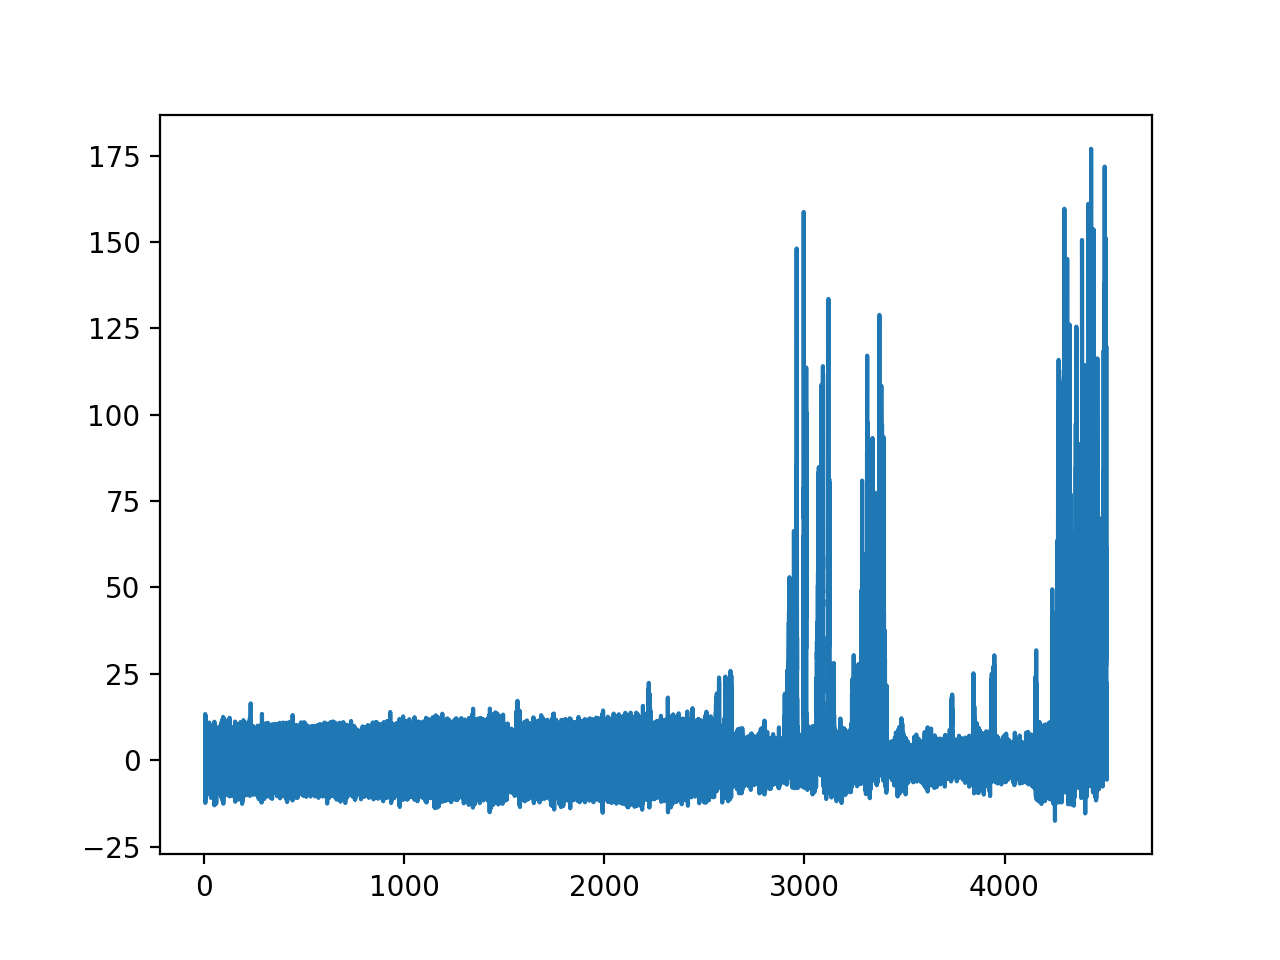

In [9]:
%matplotlib notebook
plt.subplots()
plt.plot(midpoints(vb_obt), remove_outliers(vb_obt["velocity"]))

In [10]:
np.isnan(remove_outliers(vb_obt["velocity"])).sum()

1

## Use

In [11]:
def running_in_intervals(
    running, intervals, start_key="start_time", end_key="end_time", data_key="velocity"
):
    # TODO: handle bounds
    
    intervals = np.array(intervals) # N X (start, end)
    
    start_indices = np.searchsorted(running[end_key], intervals[:, 0])
    end_indices = np.searchsorted(running[end_key], intervals[:, 1])
    
    durations = running[end_key] - running[start_key]

    values = []
    for ii, (start_index, end_index) in enumerate(zip(start_indices, end_indices)):
        
        start = intervals[ii, 0]
        end = intervals[ii, 1]
        
        raw_weights = durations[start_index:end_index+1].values
        raw_weights[0] -= start - running.loc[start_index, start_key]
        raw_weights[-1] -= running.loc[end_index, end_key] - end
        
        weights = raw_weights / raw_weights.sum()
        values.append(np.multiply(weights, running.loc[start_index:end_index, data_key]).sum())
    
    return values

In [12]:
running_in_intervals(
    pd.DataFrame({
        "start_time": np.array([0, 2, 4, 5, 6]),
        "end_time": np.array([1.5, 4, 5, 6, 8]),
        "velocity": np.arange(5)
    }), 
    [(4.0, 8)]
)

[3.25]